# Reading articles from Wikipedia 
based on the list of names
https://pypi.org/project/wikipedia/

In [236]:
#import wikipedia
#import requests
import pandas as pd
import glob
import csv

## Scrape articles for WE Women leaders

In [3]:
# Read the list of Women WE names and countries
df = pd.read_csv('WE_name_country.csv')
df.head()

,name,country
0,Mahsa Abdolzadeh,Austria
1,Claudia Arpa,Austria
2,Christine Aschbacher,Austria
3,Gertrude Aubauer,Austria
4,Claudia Bandion-Ortner,Austria


In [29]:
print('Number of rows:', len(df))
df = df.dropna()
print('Number of rows after dropping NA:', len(df))

Number of rows: 1794
Number of rows after dropping NA: 1668


In [30]:
#Save list of countries
country_list = df.country.unique()

# Number of articles in initial list by country
df.groupby('country').count()

,name
country,
Austria,92
Belgium,149
France,490
Germany,533
Lienchshtein,14
Luxembourg,25
Monaco,11
Netherlands,218
Switzerland,136


In [141]:
country = country_list[2]
print(country)
df['name'].iloc[:][df.country == country]

France


241       Delphine Arnault
242        Catherine Barba
243      Patricia Barbizet
244         Michèle Bellon
245          Sophie Bellon
              ...         
852              Rama Yade
853     Estelle Youssouffa
854         Hélène Zannier
855    Marie-Jo Zimmermann
856          Souad Zitouni
Name: name, Length: 490, dtype: object

In [169]:
df.iloc[639]

name       Yvette Roudy
country          France
Name: 765, dtype: object

In [170]:
# Save content of Wiki article pages from the list
articles = []

# Change country 
country = country_list[2]

for n in df['name'].iloc[639:][df.country == country]:
    try:
        page = wikipedia.page(n)
    except wikipedia.exceptions.DisambiguationError as e:
        print(e.options)
    except wikipedia.exceptions.PageError as e:
        print(e)
    except requests.exceptions.ConnectionError as e:
        e.status_code = "Connection refused"
    else:
        text = page.content
        # Save only articles that are over 800 symbols
        if len(text) > 10:
            articles.append(text)
print('Articles downloaded:', len(articles))

Page id "nicole sanger" does not match any pages. Try another id!
Page id "martinez vassal" does not match any pages. Try another id!
Articles downloaded: 90


In [171]:
# How many articles has been downloaded 
print('Articles downloaded:', len(articles), 'for', country)
# what is the first article
print('First article:', articles[0][:100])
# what is the last article
print('Last article:', articles[-1][:100])

Articles downloaded: 90 for France
First article: Yvette Roudy (born 10 April 1929) is a French politician. She served as a member of the National Ass
Last article: Souad Zitouni (Arabic: سعاد زيتوني‎‎; born 23 April 1974 in Boukadir) is a French lawyer and politic


In [172]:
# Save downloaded acticles into CSV file
dic = {'articles': articles}
articles_df = pd.DataFrame(dic)
filename = country +'_articles_5.csv'
articles_df.to_csv('WE_articles/' + filename)

## Importing saved articles

In [237]:
# Read the list of Women WE names
df = pd.read_csv('WE_name_country.csv')
#Save list of countries
country_list = df.country.unique()

# Import all CSV files from all Wiki articles and save them to one list
articles_df = pd.DataFrame({'articles': [], 'country': []})

for country in country_list:
    filename = country +'_*.csv'
    files = glob.glob('WE_articles/' + filename)
    
    all_articles = []
    for file in files:
        read_handle = open(file, "r")
        text = list(csv.reader(read_handle, delimiter=","))        
        for article in text[1:]:
            all_articles.append(article[1])     
    
    country_df = pd.DataFrame({'articles': all_articles, 'country': country})
    articles_df = pd.concat([articles_df, country_df], ignore_index=True)

# How many articles has been read
print('Number of articles:', len(articles_df))

# Drop duplicates
articles_df = articles_df.drop_duplicates()

# Count the number of rows after
lenAfter = len(articles_df)
print("After de-dupe: " + str(lenAfter))
articles_df.head()

Number of articles: 2046
After de-dupe: 1594


,articles,country
0,"Mahsa or Mahsā (Persian: مهسا, lit. 'moon-like...",Austria
1,Claudia Arpa (born 12 November 1967) is an Aus...,Austria
2,Christine Aschbacher (born 10 July 1983) was a...,Austria
3,Gertrude Aubauer (born 13 July 1951) is an Aus...,Austria
4,Claudia Bandion-Ortner (born 30 November 1966)...,Austria


In [238]:
# Number of articles in initial list by country
articles_df.groupby('country').count()

,articles
country,
Austria,82
Belgium,144
France,475
Germany,508
Lienchshtein,14
Luxembourg,23
Monaco,11
Netherlands,206
Switzerland,131


## Cleaning and tokenisation
- Removing headers - https://www.w3schools.com/python/python_regex.asp
- Removing stop words and numbers
- Stemming and lemmitisation
- Tokenisation

In [183]:
import re
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [213]:
# Based on https://www.geeksforgeeks.org/nlp-gensim-tutorial-complete-guide-for-beginners/

all_tokens = []

# import stopwords
stop_words = stopwords.words('english') + ['de', 'since', 'le', 'la', 'et', 'also', 'isbn', 'th']
wnl = WordNetLemmatizer()

# Check for latin alphabet 
# https://stackoverflow.com/questions/27084617/detect-strings-with-non-english-characters-in-python
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True


for article in articles_df.articles:
    # Removing section headers and new line breaks
    text = re.sub("==.*==",'', article)
    text = re.sub("\n",'', text)
    
    # Convert a document into a list of tokens 
    # This lowercases, tokenizes, removes numerical values
    tokens = simple_preprocess(text)
    
    doc_out = []
    for word in tokens:    
        if word not in stop_words:  # to remove stopwords
            if isEnglish(word):
                Lemmatized_Word = wnl.lemmatize(word)  # lemmatize
                doc_out.append(Lemmatized_Word)
    
    all_tokens.append(doc_out)

# Print out infromation about articles and number of tokens for top 15
print('Tokens groups:', len(all_tokens),'\n')

print('\nFirst 15 articles\n')
print("{0:7}{1:10}".format("-No-","--Tokens--"))
for x, tokens in enumerate(all_tokens[:15]):
    print("{0:3}{1:10}".format(x + 1, len(tokens)))

Tokens groups: 1594 


First 15 articles

-No-   --Tokens--
  1       107
  2       123
  3       195
  4       127
  5       108
  6        61
  7       671
  8       169
  9       190
 10       223
 11        43
 12       206
 13        12
 14       135
 15       284


# Dictionary - Corpus - LDA

In [187]:
from gensim.corpora.dictionary import Dictionary
from gensim.corpora import MmCorpus
from gensim.models import LdaModel, LdaMulticore, CoherenceModel
import matplotlib.pyplot as plt

In [233]:
# create dictionary - a map of unique tokens
dictionary = Dictionary(all_tokens)
dictionary.filter_extremes(no_below = 30, no_above = 0.7)
print('Dictionary length:', len(dictionary.keys()))

# 100 tokens by frequency for cleaned up dictionary
t_most_freq = dictionary.most_common(250)
print('Top 20 tokens by frequency\n')

num = 1
for t, f in t_most_freq[:20]:
    print(str(num) + '.', t, '-', f)
    num = num + 1


# Create a MmCorpus: corpus
corpus = [dictionary.doc2bow(token) for token in all_tokens]
print('\nCorpus length:', len(corpus))

Dictionary length: 1174
Top 20 tokens by frequency

1. party - 3286
2. election - 2787
3. german - 2422
4. french - 1721
5. elected - 1715
6. state - 1676
7. committee - 1673
8. council - 1512
9. minister - 1491
10. group - 1479
11. national - 1466
12. federal - 1409
13. became - 1382
14. board - 1365
15. served - 1340
16. parliament - 1302
17. parliamentary - 1292
18. university - 1240
19. president - 1221
20. first - 1167

Corpus length: 1594


In [234]:
# Writing top 250 tokens for all articles by frequency to a CSV file
top250_df = pd.DataFrame(t_most_freq)
top250_df.columns = ['token', 'frequency']
top250_df.to_csv('output/frequency_top_250.csv', index=False, header = True)

In [296]:
# save dictionary to disk
dictionary.save('WE_Wiki_dictionary.dict')

# save corpus to disk
MmCorpus.serialize("WE_Wiki_corpus.mm", corpus)

## TF-IDF

In [191]:
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS

In [192]:
# Term frequency - inverse document frequency model
tfidf = TfidfModel(corpus)

In [193]:
article = 87
print('\nTop-10 tokens for article No', article, '\n')
tfidf_int = tfidf[corpus[(article - 1)]]

# Sort the weights from highest to lowest: sorted_tfidf_weights
sorted_tfidf_weights = sorted(tfidf_int, key=lambda w: w[1], reverse=True)

# Print the top 10 weighted words
for term_id, weight in sorted_tfidf_weights[:10]:
    print("{0:15}{1:10}".format(dictionary.get(term_id), weight))


Top-10 tokens for article No 87 

chamber        0.27830236796777985
boyfriend      0.2567065082575667
murdered       0.2567065082575667
cd             0.24747770053362794
survived       0.24747770053362794
discovered     0.24342607453935608
apartment      0.23967485478320502
admitted       0.22162057455743228
aged           0.21239176683349353
flanders       0.21239176683349353


### Bigrams

In [197]:
# Train a toy phrase model on our training corpus.
phrase_model = Phrases(all_tokens, min_count = 10, threshold = 50, connector_words = ENGLISH_CONNECTOR_WORDS)

print(phrase_model)

# Finding bigrams in the interview 
bigrams = phrase_model.find_phrases(all_tokens)

Phrases<208255 vocab, min_count=10, threshold=50, max_vocab_size=40000000>


In [198]:
#Saving Bigrams as a dictionary
bigrams_dic = {'bigram': [], 'score': []}
for i in bigrams:
    bigrams_dic['bigram'].append(i)
    bigrams_dic['score'].append(bigrams[i])
bigrams_df = pd.DataFrame(bigrams_dic)
bigrams_df = bigrams_df.sort_values( by = ['score'], ascending = False)
bigrams_df = bigrams_df.reset_index(drop=True)

# Write bigrams to a CSV
bigrams_df.to_csv('output/ee_full_wiki_bigrams.csv')
# Showing top 15 bigrams for all articles
bigrams_df.head(15)

,bigram,score
0,pluijm_vrede,5206.375000
1,charrette_labadie,5044.238754
2,armin_laschet,4932.355263
3,laroche_joubert,4880.976562
4,pim_fortuyn,4859.283333
5,widmer_schlumpf,4733.068182
6,widmann_mauz,4724.120983
7,pannier_runacher,4338.645833
8,wieczorek_zeul,4143.481834
9,stark_watzinger,4038.185596


### Bigram visualisation
Based on: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-bigrams/

In [199]:
from nltk import bigrams as nltkbigrams
from collections import Counter
import itertools
import networkx as nx

In [215]:
article_bigram = [list(nltkbigrams(article)) for article in all_tokens]
#article_bigram[0][:10]

# Flatten list of bigrams
bigrams_list = list(itertools.chain(*article_bigram))

# Create counter of words in bigrams list
bigram_counts = Counter(bigrams_list)

bigram_df = pd.DataFrame(bigram_counts.most_common(50),
                             columns=['bigram', 'count'])

bigram_df.head(10)

,bigram,count
0,"(member, board)",607
1,"(national, assembly)",526
2,"(federal, election)",478
3,"(parliamentary, group)",471
4,"(member, bundestag)",388
5,"(democratic, party)",384
6,"(german, politician)",372
7,"(house, representative)",362
8,"(became, member)",318
9,"(legislative, election)",306


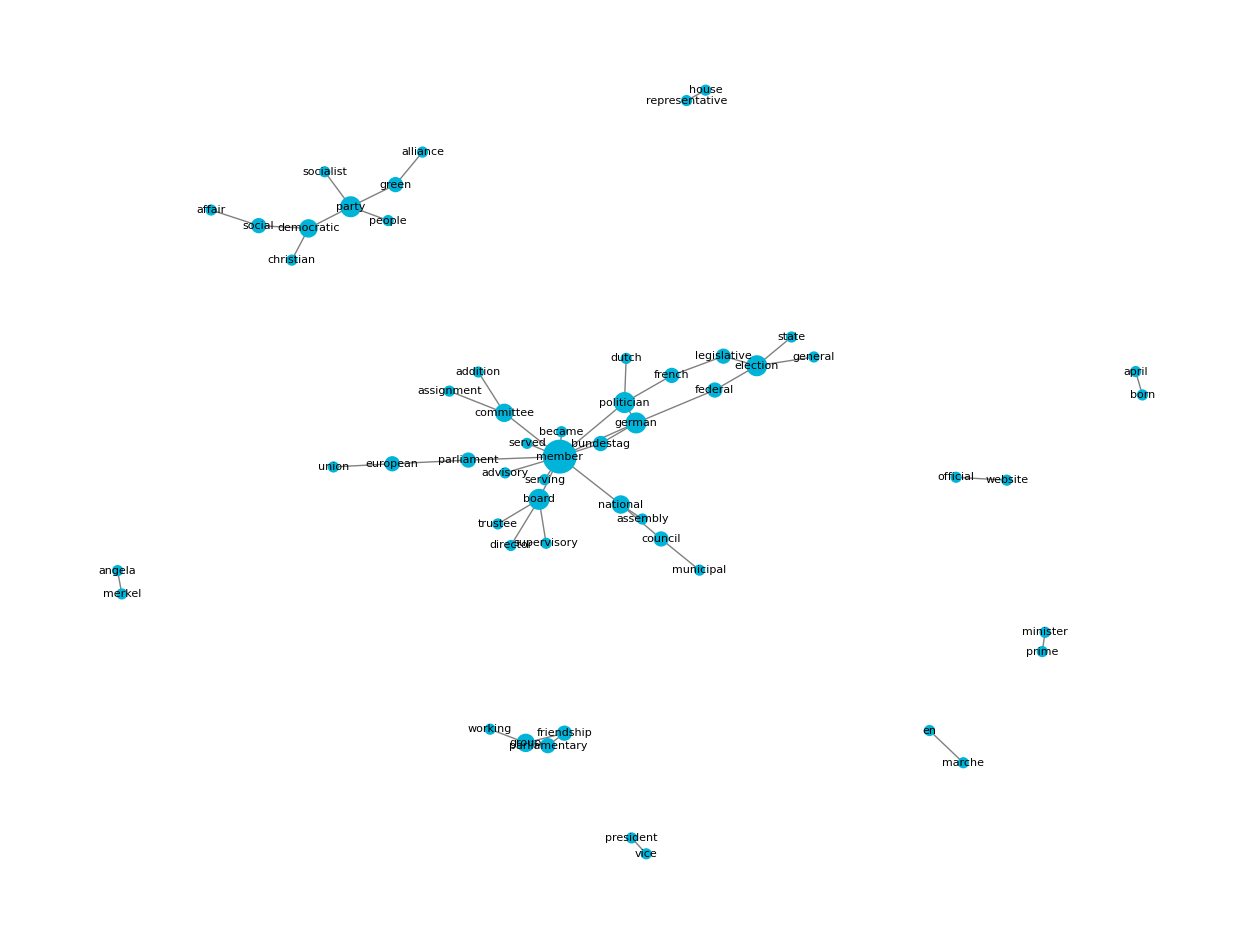

In [239]:
# Create dictionary of edges and their weights
d = bigram_df.set_index('bigram').T.to_dict('records')

# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))
    
# Use node degree as the node size

fig, ax = plt.subplots(figsize=(16, 12))

pos = nx.spring_layout(G, k=2)

d = dict(G.degree)

nx.draw(G, pos,
        font_size=8,
        width=1,
        edge_color='grey',
        node_color='#00b4d9',
        with_labels = True, 
        nodelist=d.keys(), 
        node_size=[v * 50 for v in d.values()])
plt.show()

In [206]:
list(G.adj['bundestag'])

['member', 'german']

### Trigrams

In [217]:
# Train trigram model on all tockets
trigram  = Phrases(phrase_model[all_tokens], min_count = 10)
#print(trigram)

# Create a list of all trigrams
trigram_list = []
for token in all_tokens:
    trigrams_ = [t for t in trigram[phrase_model[token]] if t.count('_')==2]
    if len(trigrams_) > 0:
        trigram_list.append(trigrams_) 
    
print('Total number of documents with trigrams:', len(trigram_list))

# create dictionary of trigrams
trigram_dic = Dictionary(trigram_list)
print('Number of unique trigrams:', len(trigram_dic.keys()))

# Top 100 tigrams by frequency in all articles
trigram_most_freq = trigram_dic.most_common(100)
print('\nTop 20 trigrams by frequency\n')

num = 1
for t, f in trigram_most_freq[:20]:
    print(str(num) + '.', t, '-', f)
    num = num + 1

Total number of documents with trigrams: 1223
Number of unique trigrams: 199

Top 20 trigrams by frequency

1. social_democratic_party - 211
2. french_legislative_election - 189
3. addition_committee_assignment - 154
4. parliamentary_friendship_group - 149
5. member_board_trustee - 136
6. member_house_representative - 120
7. french_national_assembly - 109
8. von_der_leyen - 105
9. christian_democratic_union - 103
10. ex_officio_member - 102
11. official_website_german - 97
12. national_assembly_france - 94
13. north_rhine_westphalia - 90
14. member_supervisory_board - 89
15. bundestag_biography_english - 78
16. free_democratic_party - 73
17. chancellor_angela_merkel - 69
18. government_prime_minister - 58
19. en_marche_lrem - 57
20. university_applied_science - 55


## LDA

In [228]:
# Train our lda model
lda_model = LdaModel(corpus, num_topics = 9, iterations = 10, 
                     id2word=dictionary, passes = 10, random_state = 100)

# For each topic, we will explore the words occuring in that topic and its relative weight.
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.039*"committee" + 0.034*"french" + 0.031*"parliamentary" + 0.026*"group" + 0.026*"assembly" + 0.025*"election" + 0.020*"national" + 0.018*"german" + 0.015*"parliament" + 0.015*"affair"
Topic: 1 
Words: 0.036*"german" + 0.026*"state" + 0.024*"bundestag" + 0.017*"elected" + 0.017*"party" + 0.016*"green" + 0.014*"federal" + 0.014*"election" + 0.014*"became" + 0.014*"berlin"
Topic: 2 
Words: 0.046*"party" + 0.034*"election" + 0.023*"left" + 0.017*"elected" + 0.016*"candidate" + 0.014*"german" + 0.012*"state" + 0.011*"vote" + 0.010*"green" + 0.010*"leader"
Topic: 3 
Words: 0.017*"french" + 0.014*"paris" + 0.013*"france" + 0.012*"director" + 0.010*"board" + 0.009*"president" + 0.008*"minister" + 0.008*"first" + 0.008*"year" + 0.007*"child"
Topic: 4 
Words: 0.012*"woman" + 0.010*"year" + 0.010*"merkel" + 0.010*"german" + 0.009*"business" + 0.008*"germany" + 0.008*"company" + 0.008*"one" + 0.008*"university" + 0.007*"world"
Topic: 5 
Words: 0.031*"french" + 0.022*"election" 

In [224]:
query = 'Leadership is the ability of an individual or a group of people to influence and guide followers or members of an organization, society or team.'
vec_bow = dictionary.doc2bow(query.lower().split())

# convert the query to LSI space
vec_lda = lda_model[vec_bow]  
# This shows how the query relates to the topics
vec_lda

[(0, 0.01000084),
 (1, 0.01000084),
 (2, 0.01000084),
 (3, 0.01000084),
 (4, 0.01000084),
 (5, 0.25303364),
 (6, 0.01000084),
 (7, 0.01000084),
 (8, 0.01000084),
 (9, 0.01000084),
 (10, 0.01000084),
 (11, 0.01000084),
 (12, 0.01000084),
 (13, 0.01000084),
 (14, 0.01000084),
 (15, 0.01000084),
 (16, 0.01000084),
 (17, 0.01000084),
 (18, 0.5669513),
 (19, 0.01000084)]

In [178]:
# probability of a word belonging to a topic
test_words = ['leader']
for topic, prob in lda_model.get_term_topics(test_words):
     print('Word:', test_words, ' - belongs to\nTopic: {} \nProbability: {}'.format(topic, prob))

## Optimal number of topics

https://radimrehurek.com/gensim/models/coherencemodel.html

Best coherence for umass is typically the minimum. Best coherence for c_v is typically the maximum. Umass is faster than c_v, but in my experience c_v gives better scores for optimal number of topics. This is not a hard decision rule. It depends on the use case. If you're evaluating topics for human readability you would probably want to compare a few models with low umass to see how the top keywords look with something like pyLDAvis. Vice versa for c_v. (https://groups.google.com/g/gensim/c/Ybja9B15F1E?pli=1)

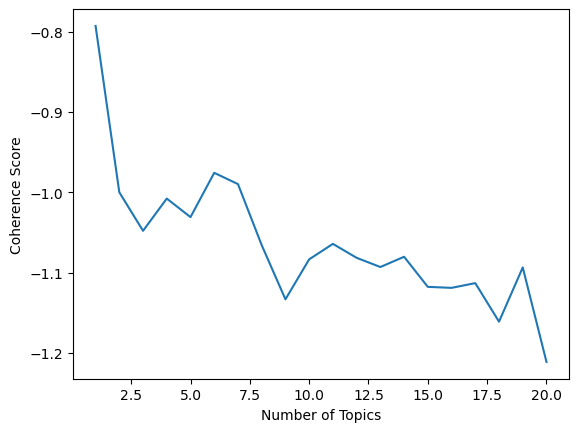

In [220]:
topics = []
score = []
for i in range(1,21,1):
    lda_model = LdaMulticore(corpus = corpus, id2word = dictionary, 
                             iterations = 10, num_topics = i, 
                             workers = 4, passes = 10, 
                             random_state = 100)
    cm = CoherenceModel(model = lda_model, corpus = corpus, dictionary = dictionary, 
                        coherence='u_mass')
    topics.append(i)
    score.append(cm.get_coherence())
    
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [226]:
cm.get_coherence_per_topic()

[-0.9751772311391153,
 -1.2944137374897422,
 -1.0640979397949981,
 -1.234631323066532,
 -1.5056652187666792,
 -1.0789179933031854,
 -0.9199061258859044,
 -1.1590698228728658,
 -1.3046277649706826,
 -1.170130592132859,
 -1.0378752813903924,
 -1.4302317071673252,
 -1.3249352385648325,
 -1.3557143218070151,
 -1.0111552859220028,
 -1.136557516243645,
 -1.61853945941535,
 -1.672381680908647,
 -0.9134396502256017,
 -1.0176048830247435]

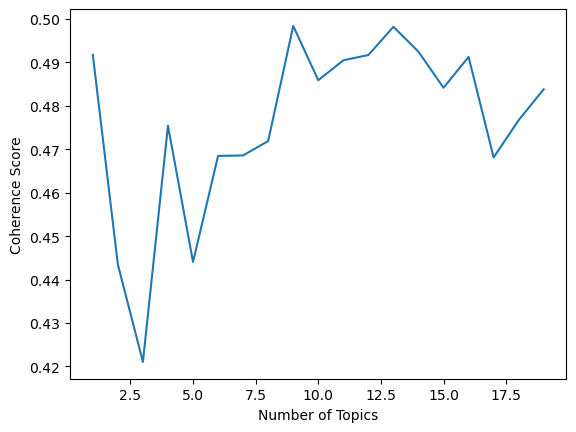

In [227]:
# Calculating the coherence score using C_v
topics = []
score = []
for i in range(1,20,1):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, 
                             iterations=10, num_topics=i, 
                             workers = 4, passes=10, random_state=100)
    cm = CoherenceModel(model=lda_model, texts = all_tokens, corpus=corpus, 
                        dictionary=dictionary, 
                        coherence='c_v')
    topics.append(i)
    score.append(cm.get_coherence())
    
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

## Visualisation

In [210]:
import pyLDAvis
import pyLDAvis.gensim

In [229]:
#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.109292 -0.034227       1        1  14.896161
7      0.061037 -0.089925       2        1  14.758313
6     -0.081810 -0.003537       3        1  13.995696
5      0.019976  0.125872       4        1  11.115294
3     -0.088659  0.062830       5        1  10.245310
1      0.047378 -0.082627       6        1  10.081310
8     -0.029949 -0.015510       7        1   8.913184
2      0.028146 -0.018224       8        1   8.275262
0      0.153174  0.055348       9        1   7.719469, topic_info=           Term         Freq        Total Category  logprob  loglift
830      french  1632.000000  1632.000000  Default  30.0000  30.0000
109      german  2395.000000  2395.000000  Default  29.0000  29.0000
32    committee  1570.000000  1570.000000  Default  28.0000  28.0000
35      council  1476.000000  1476.000000  Default  27.0000  27.0000
1015      dutch   702.000000   702.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
438    european   124.891206   927.121039   Topic9  -4.7864   0.5568
155      deputy   108.770427   726.109077   Topic9  -4.9246   0.6630
64        party   172.191123  3281.652182   Topic9  -4.4652  -0.3861
523      france    98.615045   744.813412   Topic9  -5.0226   0.5395
43      elected   108.974946  1684.627534   Topic9  -4.9227  -0.1768

[561 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1156      1  0.046264  abitur
1156      2  0.293007  abitur
1156      4  0.015421  abitur
1156      5  0.015421  abitur
1156      6  0.370114  abitur
...     ...       ...     ...
150       9  0.019919   youth
915       2  0.017537  zurich
915       3  0.035075  zurich
915       5  0.017537  zurich
915       7  0.911941  zurich

[3250 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 7, 6, 4, 2, 9, 3, 1])